In [1]:
import pandas as pd
intervals= [
    {'lower': 'q_1', 'upper': 'q_99', 'alpha': 0.02},    # 98% PI
    {'lower': 'q_2', 'upper': 'q_97', 'alpha': 0.05}, # 95% PI
    {'lower': 'q_5', 'upper': 'q_95', 'alpha': 0.1},     # 90% PI
    {'lower': 'q_10', 'upper': 'q_90', 'alpha': 0.2},    # 80% PI
    {'lower': 'q_15', 'upper': 'q_85', 'alpha': 0.3},    # 70% PI
    {'lower': 'q_20', 'upper': 'q_80', 'alpha': 0.4},    # 60% PI
    {'lower': 'q_25', 'upper': 'q_75', 'alpha': 0.5},    # 50% PI
    {'lower': 'q_30', 'upper': 'q_70', 'alpha': 0.6},    # 40% PI
    {'lower': 'q_35', 'upper': 'q_65', 'alpha': 0.7},    # 30% PI
    {'lower': 'q_40', 'upper': 'q_60', 'alpha': 0.8},    # 20% PI
    {'lower': 'q_45', 'upper': 'q_55', 'alpha': 0.9}     # 10% PI
]
def create_ensemble_model(models, intervals, input_path_template="{model}_base_stage_holi_pf_ol_42test.csv",
                         output_path="../res/ensemble_model_with_intervals.csv"):
    # 提取分位数列名
    quantile_columns = list(set([interval['lower'] for interval in intervals] +
                              [interval['upper'] for interval in intervals]))
    required_columns = ['point', 'true', 'date', 'week_ahead'] + quantile_columns

    # 读取并过滤每个模型的数据
    dfs = []
    for model in models:
        file_path = input_path_template.format(model=model)
        df = pd.read_csv(file_path)  # 如果文件非 CSV，需调整
        if 'mode' in df.columns:
            df = df[(df['mode'] == 'train_seed42') | (df['mode'] == 'train')][required_columns]
        else:
            df = df[required_columns]
        df['model'] = model  # 添加模型名称用于追踪
        dfs.append(df)

    # 合并所有数据框
    combined_df = pd.concat(dfs, ignore_index=True)

    # 按 date 和 week_ahead 对齐预测
    pivot_df = combined_df.pivot_table(
        index=['date', 'week_ahead', 'true'],
        columns='model',
        values=['point'] + quantile_columns,
        aggfunc='mean'
    ).reset_index()

    # 展平多级列名
    pivot_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in pivot_df.columns]

    # 计算集成点预测
    pivot_df['point'] = pivot_df[[f'point_{model}' for model in models]].mean(axis=1, skipna=True)

    # 计算集成预测区间，保持原始分位数列名
    for interval in intervals:
        lower_col = interval['lower']
        upper_col = interval['upper']
        pivot_df[lower_col] = pivot_df[[f'{lower_col}_{model}' for model in models]].mean(axis=1, skipna=True)
        pivot_df[upper_col] = pivot_df[[f'{upper_col}_{model}' for model in models]].mean(axis=1, skipna=True)

    # 选择输出列
    output_columns = ['date', 'week_ahead', 'true', 'point'] + \
                     [interval['lower'] for interval in intervals] + \
                     [interval['upper'] for interval in intervals]
    ensemble_df = pivot_df[output_columns]

    # 保存集成结果
    ensemble_df.to_csv(output_path, index=False)

    # 检查缺失预测
    missing_data = pivot_df[[f'point_{model}' for model in models] +
                           [f'{q}_{model}' for q in quantile_columns for model in models]].isna().any(axis=1)
    if missing_data.any():
        print("警告：某些模型在特定 date/week_ahead 组合下缺少预测数据。")
        print(pivot_df[missing_data][['date', 'week_ahead']])

    return ensemble_df

# ensemble_df = create_ensemble_model(['itransformer','gru','tcn','Nbeats'],intervals,  input_path_template="{model}_base_stage_holi_pf_ol_42test.csv",
#                          output_path="../res/ensemble_model_with_intervals.csv")
ensemble_df2 = create_ensemble_model(['itransformer','gru','tcn','Nbeats'],intervals, input_path_template="../res/{model}/{model}_base_stage_holi_pf_42test.csv",
                         output_path="../res/ensemble_model_with_intervals.csv")
ensemble_df3 = create_ensemble_model(['itransformer','gru','tcn','Nbeats'],intervals, input_path_template="../res/{model}/{model}_base_stage_42test.csv",
                         output_path="../res/ensemble_model_with_intervals_base_stage.csv")

ensemble_df4 = create_ensemble_model(['itransformer','gru','tcn','Nbeats'],intervals, input_path_template="../res/{model}/{model}_base_42test.csv",
                         output_path="../res/ensemble_model_with_intervals_base.csv")


In [2]:
# def create_seed_ensemble_model(model_name, mode, seeds, intervals,
#                              input_path_template="{model}_{mode}_{seed}test.csv",
#                              output_path="../res/{model}_{mode}_avg.csv"):
#     # 提取分位数列名
#     quantile_columns = list(set([interval['lower'] for interval in intervals] +
#                                [interval['upper'] for interval in intervals]))
#     required_columns = ['point', 'true', 'date', 'week_ahead'] + quantile_columns
#
#     # 读取所有种子数据
#     dfs = []
#     for seed in seeds:
#         file_path = input_path_template.format(model=model_name,mode=mode, seed=seed)
#         df = pd.read_csv(file_path)
#         if 'mode' in df.columns:
#             df = df[df['mode'] == 'train'][required_columns]
#         else:
#             df = df[required_columns]
#         df['seed'] = f"seed{seed}"  # 标记种子来源
#         dfs.append(df)
#
#     # 合并数据
#     combined_df = pd.concat(dfs, ignore_index=True)
#
#     # 按 date 和 week_ahead 对齐预测
#     pivot_df = combined_df.pivot_table(
#         index=['date', 'week_ahead', 'true'],
#         columns='seed',
#         values=['point'] + quantile_columns,
#         aggfunc='mean'
#     ).reset_index()
#
#     # 展平列名
#     pivot_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in pivot_df.columns]
#
#     # 计算集成点预测（多种子平均）
#     seed_columns = [f'point_seed{seed}' for seed in seeds]
#     pivot_df['point'] = pivot_df[seed_columns].mean(axis=1)
#
#     # 计算集成预测区间
#     for interval in intervals:
#         lower_col = interval['lower']
#         upper_col = interval['upper']
#         pivot_df[lower_col] = pivot_df[[f'{lower_col}_seed{seed}' for seed in seeds]].mean(axis=1)
#         pivot_df[upper_col] = pivot_df[[f'{upper_col}_seed{seed}' for seed in seeds]].mean(axis=1)
#
#     # 选择输出列
#     output_columns = ['date', 'week_ahead', 'true', 'point'] + \
#                     [interval['lower'] for interval in intervals] + \
#                     [interval['upper'] for interval in intervals]
#     ensemble_df = pivot_df[output_columns]
#
#     # 保存结果
#     ensemble_df.to_csv(output_path.format(model=model_name,mode=mode), index=False)
#
#
# mode = 'base_stage_holi_pf_ol'
# create_seed_ensemble_model('gru',mode,[42,123,456],intervals)
# create_seed_ensemble_model('tcn',mode,[42,123,456],intervals)
# create_seed_ensemble_model('itransformer',mode,[42,123,456],intervals)
# create_seed_ensemble_model('Nbeats',mode,[42,123,456],intervals)
#
#
# mode = 'base_stage_holi_pf'
# create_seed_ensemble_model('gru',mode,[42,123,456],intervals)
# create_seed_ensemble_model('tcn',mode,[42,123,456],intervals)
# create_seed_ensemble_model('itransformer',mode,[42,123,456],intervals)
# create_seed_ensemble_model('Nbeats',mode,[42,123,456],intervals)

In [3]:
import numpy as np  
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # 避免分母为 0（如果 y_true + y_pred = 0，替换成很小的数）
    denominator = (np.abs(y_true) + np.abs(y_pred))
    denominator = np.where(denominator == 0, 1e-10, denominator)
    return np.mean(np.abs(y_pred - y_true) / denominator) * 100  # 百分比形式

def interval_score(y, lower, upper, alpha):
    width = upper - lower
    penalty_lower = (2 / alpha) * (lower - y) * (y < lower)
    penalty_upper = (2 / alpha) * (y - upper) * (y > upper)
    return width + penalty_lower + penalty_upper

def calculate_coverate(t,rate='95'):
    intervals = {
              "95":  {'lower': 'q_2', 'upper': 'q_97'},  # 95%
              "80":   {'lower': 'q_10', 'upper': 'q_90'},     # 80%
              "50":   {'lower': 'q_25', 'upper': 'q_75'},     # 50%
    }
    interval = intervals[rate]

    y = t['true']
    metrics = {}
    lower = t[interval['lower']] if interval['lower'] else -np.inf
    upper = t[interval['upper']] if interval['upper'] else np.inf
    correct = (y >= lower) & (y <= upper)
    coverate = np.mean(correct)
    return coverate

def calculate_wis(row):
    y = row['true']
    median = y
    K = len(intervals)  # 区间数量

    # 计算所有区间的 IS
    interval_scores = sum(
        0.5 * interval['alpha'] *interval_score(y, row[interval['lower']], row[interval['upper']], interval['alpha'])
        for interval in intervals
    )

    # 中位数误差
    median_penalty = 0.5 * abs(y - median)

    # WIS
    wis = (interval_scores + median_penalty) / (K + 0.5)
    return wis

def median_absolute_error(y_true, y_pred):
    absolute_errors = np.abs(y_true - y_pred)
    return np.median(absolute_errors)

def calculate_accuracy_with_tolerance(true_values, pred_values, tolerance=0.25):
    lower_bound = true_values * (1 - tolerance)
    upper_bound = true_values * (1 + tolerance)
    correct = (pred_values >= lower_bound) & (pred_values <= upper_bound)
    accuracy = np.mean(correct)
    return accuracy

In [4]:
# def create_avg_model(models, intervals,
#                          output_path="../res/ensemble_model.csv"):
#     # 提取分位数列名
#     quantile_columns = list(set([interval['lower'] for interval in intervals] +
#                               [interval['upper'] for interval in intervals]))
#     required_columns = ['point', 'true', 'date', 'week_ahead'] + quantile_columns
#
#     # 读取并过滤每个模型的数据
#     dfs = []
#     for model in models:
#         file_path = model
#         df = pd.read_csv(file_path)  # 如果文件非 CSV，需调整
#         if 'mode' in df.columns:
#             df = df[df['mode'] == 'train'][required_columns]
#         else:
#             df = df[required_columns]
#         df['model'] = model  # 添加模型名称用于追踪
#         dfs.append(df)
#
#     # 合并所有数据框
#     combined_df = pd.concat(dfs, ignore_index=True)
#
#     # 按 date 和 week_ahead 对齐预测
#     pivot_df = combined_df.pivot_table(
#         index=['date', 'week_ahead', 'true'],
#         columns='model',
#         values=['point'] + quantile_columns,
#         aggfunc='mean'
#     ).reset_index()
#
#     # 展平多级列名
#     pivot_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in pivot_df.columns]
#
#     # 计算集成点预测
#     pivot_df['point'] = pivot_df[[f'point_{model}' for model in models]].mean(axis=1, skipna=True)
#
#     # 计算集成预测区间，保持原始分位数列名
#     for interval in intervals:
#         lower_col = interval['lower']
#         upper_col = interval['upper']
#         pivot_df[lower_col] = pivot_df[[f'{lower_col}_{model}' for model in models]].mean(axis=1, skipna=True)
#         pivot_df[upper_col] = pivot_df[[f'{upper_col}_{model}' for model in models]].mean(axis=1, skipna=True)
#
#     # 选择输出列
#     output_columns = ['date', 'week_ahead', 'true', 'point'] + \
#                      [interval['lower'] for interval in intervals] + \
#                      [interval['upper'] for interval in intervals]
#     ensemble_df = pivot_df[output_columns]
#
#     # 保存集成结果
#     ensemble_df.to_csv(output_path, index=False)
#
#     # 检查缺失预测
#     missing_data = pivot_df[[f'point_{model}' for model in models] +
#                            [f'{q}_{model}' for q in quantile_columns for model in models]].isna().any(axis=1)
#     if missing_data.any():
#         print("警告：某些模型在特定 date/week_ahead 组合下缺少预测数据。")
#         print(pivot_df[missing_data][['date', 'week_ahead']])
#
# models = ["../res/ensemble_model_with_intervals_no_ol.csv","../res/ensemble_model_with_intervals.csv"]
# create_avg_model(models, intervals,
#                          output_path="../res/ensemble_model.csv")

select train mode
constant
-------------------------------------
select train mode
gru
-------------------------------------
select train mode
tcn
-------------------------------------
select train mode
Nbeats
-------------------------------------
select train mode
itransformer
-------------------------------------
base_stage_ensemble
-------------------------------------
ensemble_model
-------------------------------------
ensemble reduce:  15.8 %
constant :  0.7953667796500888
gru :  0.7049799903878392
tcn :  0.7484596818121155
Nbeats :  0.9015155985330665
itransformer :  0.8313442767524108
base_stage_ensemble :  0.7717978997739235
ensemble_model :  0.6698973640201982


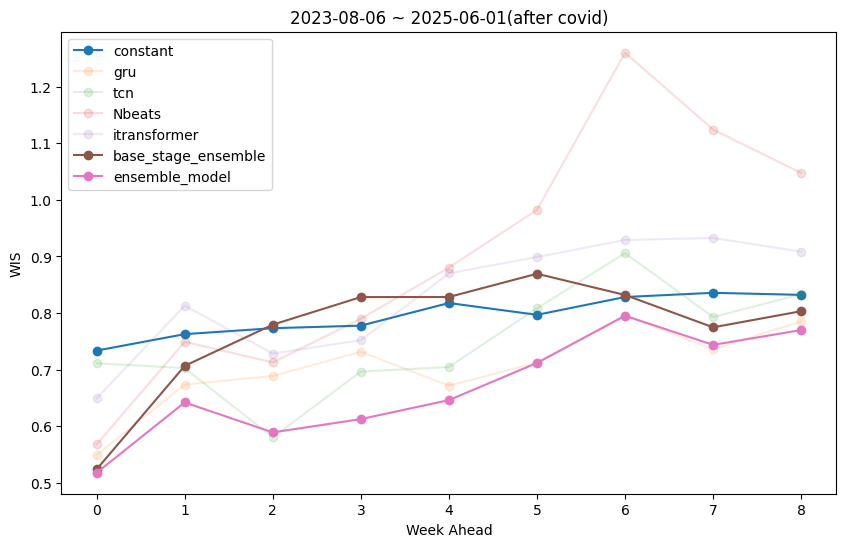

In [14]:
from datetime import timedelta
from matplotlib import pyplot as plt
import numpy  as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
# 读取所有模型的预测结果'GRU','TCN','itransformer','Nbeats','ensemble_model''ensemble_model_ol','ensemble_model_no_ol'
model_list = ['gru','tcn','Nbeats','itransformer','base_stage_ensemble','ensemble_model'] #'tcn','itransformer','Nbeats','ensemble_model'
models = ['constant']#'AWAE','AWBE' GRU_res_teacher,'ensemble_model_ol','ensemble_model_no_ol'
for model in model_list:
    models.append(f'{model}')
pred_steps = 9
original_method_res = []


def smape_score(y_true, y_pred):
    return  np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

mode = 'base_stage_holi_pf'  #'base_holi_pf' 'base_holi' 'base_pf' 'base`''base_stage_holi_pf'

seed = 42
for model in models:
    # 构建文件路径
    if model == 'constant':
        path = '../res/forc_baseline_constant3.csv'
    elif model =='gru':
        path =f'../res/{model}/{model}_{mode}_42test.csv'
    elif model =='tcn':
        path =f'../res/{model}/{model}_{mode}_42test.csv'
    elif model =='Nbeats':
        path =f'../res/{model}/{model}_{mode}_42test.csv'
    elif model =='itransformer':
        path =f'../res/{model}/{model}_{mode}_42test.csv'
    elif model=='ensemble_model':
        path = f'../res/ensemble_model_with_intervals.csv'
    elif model=='base_stage_ensemble':
        path = f'../res/ensemble_model_with_intervals_base_stage.csv'
    elif model=='base_ensemble':
        path = f'../res/ensemble_model_with_intervals_base.csv'
    else:
        path=None


    # 读取数据并过滤日期
    res = pd.read_csv(path)
    if 'mode' in res.columns:
        print('select train mode')
        res = res[(res['mode']=='train_seed42')|(res['mode']=='train')]
    res['date'] = pd.to_datetime(res['date'])
    res['date_origin'] = res['date'] - (res['week_ahead'])*timedelta(days=7)
    # Find date_origins where true < 1
    invalid_dates = res.groupby('date').filter(lambda x: (x['true'] < 1).any())['date'].unique()
    # invalid_dates = [invalid_date+timedelta(days=7) for invalid_date in invalid_dates]
    # Filter out those date_origins
    res = res[~res['date_origin'].isin(invalid_dates)]
    res = res[(res['date_origin'] >= '2023-11-26')]
    # res = res[(res['date_origin'] < '2024-11-26')]


    res = res.dropna()
    # 计算每个预测周期的RMSE
    model_rmse = []
    print(model)
    print('-------------------------------------')
    for i in range(pred_steps):
        t = res[res['week_ahead']==i]
        wis = t.apply(calculate_wis, axis=1)
        median_ae = median_absolute_error(t['true'], t['point'])
        wis_mean = np.mean(wis)
        rmse = np.sqrt(mean_squared_error(t['true'], t['point']))
        error_std = np.std(t['true']-t['point'])
        mae = mean_absolute_error(t['true'], t['point'])
        mape = mean_absolute_percentage_error(t['true'], t['point'])
        # cov_95 = calculate_coverate(t,rate='95')
        accu = calculate_accuracy_with_tolerance(t['true'], t['point'],tolerance=0.50)
        smape = symmetric_mean_absolute_percentage_error(t['true'], t['point'])
        # if model == 'baseline':
        # print('RMSE for step %d: %f' % (i, rmse))
        model_rmse.append(wis_mean)
    original_method_res.append(model_rmse)

a = np.mean(original_method_res[0])
b = np.mean(original_method_res[-1])


print('ensemble reduce: ',np.round((a-b)/a,3)*100,'%')
for i in range(len(original_method_res)):
    print(models[i],': ',np.mean(original_method_res[i]))
# 绘图
weeks = range(pred_steps)
plt.figure(figsize=(10, 6))

labels = models
alphas = [1,0.15,0.15,0.15,0.15,1,1,1,0.15,1,1]
for res, label, alpha in zip(original_method_res, labels, alphas):
    plt.plot(weeks, res, marker='o', label=label, alpha=alpha)

plt.xlabel('Week Ahead')
plt.ylabel('WIS')
plt.title('2023-08-06 ~ 2025-06-01(after covid)')
plt.legend()
plt.savefig('HK_RMSE.pdf', dpi=300, bbox_inches='tight')  # 保存为 PNG
plt.show()

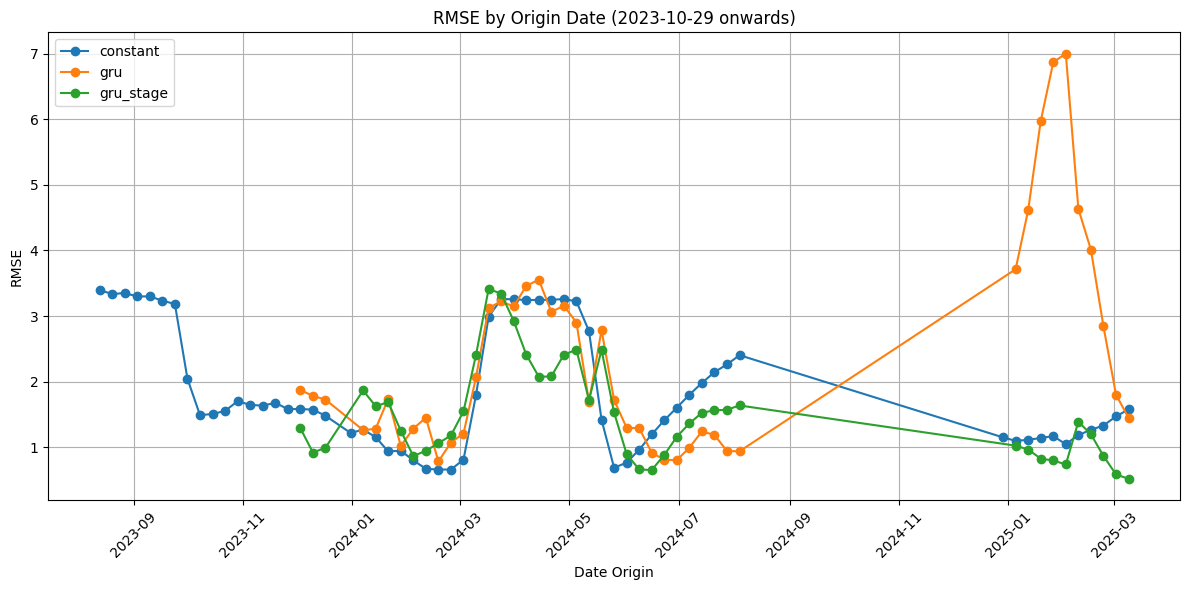

In [6]:
# 读取所有模型的预测结果
models = ['constant','gru','gru_stage']#'TCN','Nbeats','itransforer']  # 'AWAE','AWBE'
original_method_res = []
pred_steps = pred_steps

plt.figure(figsize=(12, 6))

for model in models:
    # 构建文件路径（保持你的原始路径逻辑）
    if model in ['XGB', 'ARIMA']:
        path = f'../Results/Interval_ydiff_pred/interval_{model}_rolling_test8.csv'
    elif model =='gru':
        path = '../res/gru/gru_base_holi_pf_42test.csv'
    elif model =='gru_stage':
        path = '../res/gru/gru_base_stage_holi_pf_42test.csv'
    elif model =='Nbeats':
        path = '../res/Nbeats/Nbeats_base_stage_holi_pf_42test.csv'
    elif model =='Nbeats_stage':
        path = '../res/Nbeats/Nbeats_base_stage_42test.csv'
    elif model == 'constant':
        path = '../res/forc_baseline_constant3.csv'
    elif model == 'tcn':
        path = '../res/tcn/tcn_base_pf_42test.csv'
    elif model == 'tcn_stage':
        path = '../res/tcn/tcn_base_42test.csv'
    elif model == 'itransformer':
        path = '../res/itransformer/itransformer_base_stage_holi_pf_42test.csv'
    elif model == 'itransformer_stage':
        path = '../res/itransformer/itransformer_base_stage_42test.csv'
    elif model=='ensemble_model':
        path = f'../res/ensemble_model_with_intervals.csv'
    else:
        path = f'../Results/Interval_ydiff_pred/interval_{model}_nontuning_rolling_v2_test8.csv'

    # 读取数据
    res = pd.read_csv(path)
    if 'mode' in res.columns:
        res = res[(res['mode']=='train_seed42')|(res['mode']=='train')]
    res['date'] = pd.to_datetime(res['date'])
    res['date_origin'] = res['date'] - res['week_ahead'] * timedelta(days=7)
    res = res[(res['date_origin'] > '2023-08-06')]
    invalid_dates = res.groupby('date').filter(lambda x: (x['true'] <= 1).any())['date'].unique()
    # Filter out those date_origins
    res = res[~res['date_origin'].isin(invalid_dates)]
    # res = res[~((res['date_origin'] > '2024-09-01')&(res['date_origin'] < '2024-11-01'))]
    res = res.dropna()
    # res = res[res['week_ahead']<4]
    # 按date_origin分组计算RMSE1
    rmse_by_date = res.groupby('date_origin').apply(
        lambda x: np.sqrt(mean_squared_error(x['true'], x['point']))
    ).reset_index(name='RMSE')

    # 绘制曲线
    plt.plot(rmse_by_date['date_origin'], rmse_by_date['RMSE'],
             marker='o', linestyle='-', label=model)

plt.xlabel('Date Origin')
plt.ylabel('RMSE')
plt.title('RMSE by Origin Date (2023-10-29 onwards)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()